# DC casing -- finite wells 

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
import time
from string import ascii_lowercase

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import resistivity as dc
from SimPEG import utils, maps, Report
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 12

In [3]:
# conductivities
sigma_air = 1e-6
sigma_back = 1e-2
sigma_casing = 5e6

# casing geometry
casing_b = 5e-2  
casing_t = 10e-3
casing_a = casing_b - casing_t
casing_l = [500, 1000, 2000, 4000, 8000]

In [4]:
return_electrode_r = 8000
src_a = np.r_[casing_a+casing_t/2, 0, -1.25]
src_b = np.r_[return_electrode_r, 0., -1.25]

23520
44520
86520
170520
338520


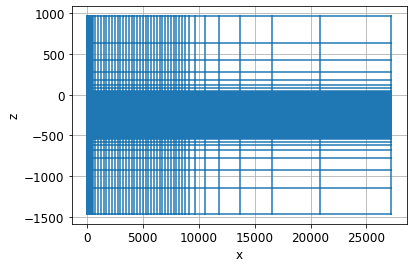

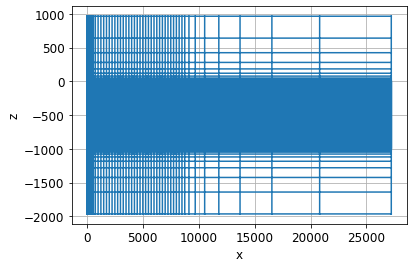

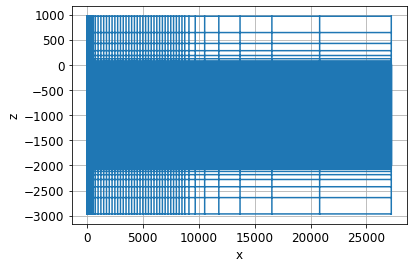

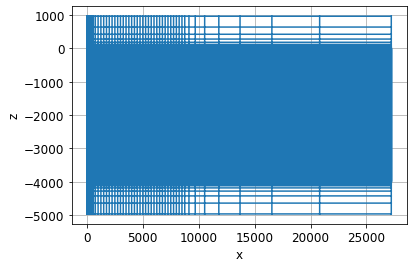

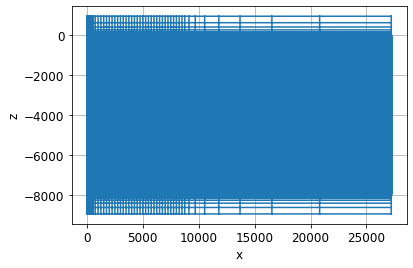

In [5]:
csz = 2.5
npadz = 12
pf = 1.5

meshes = {}

hx = casing_sim.mesh.pad_for_casing_and_data(
    casing_b,
    csx1=casing_t/4., 
    npadx=8,
    csx2=250,
    domain_x=return_electrode_r
)

for l in casing_l: 
    ncz = l/csz
    hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])
    meshes[l] = discretize.CylindricalMesh([hx, 1, hz], x0=np.r_[0,0,-hz[:-npadz].sum()])
    print(meshes[l].n_cells)
    meshes[l].plot_grid()

In [6]:
casing_indices = {}

for l, mesh in meshes.items():
    inds_casing_x = (
        (mesh.cell_centers[:, 0] > casing_a) & 
        (mesh.cell_centers[:, 0] < casing_b)
    )
    inds_casing_z = (
        (mesh.cell_centers[:, 2] < 0) &
        (mesh.cell_centers[:, 2] > -l)
    )
    casing_indices[l] = inds_casing_x & inds_casing_z
    

In [7]:
models = {}

for l, inds in casing_indices.items():
    sigma = sigma_back*np.ones(meshes[l].n_cells)
    sigma[inds] = sigma_casing
    sigma[meshes[l].cell_centers[:, 2] > 0] = sigma_air
    
    models[l] = sigma

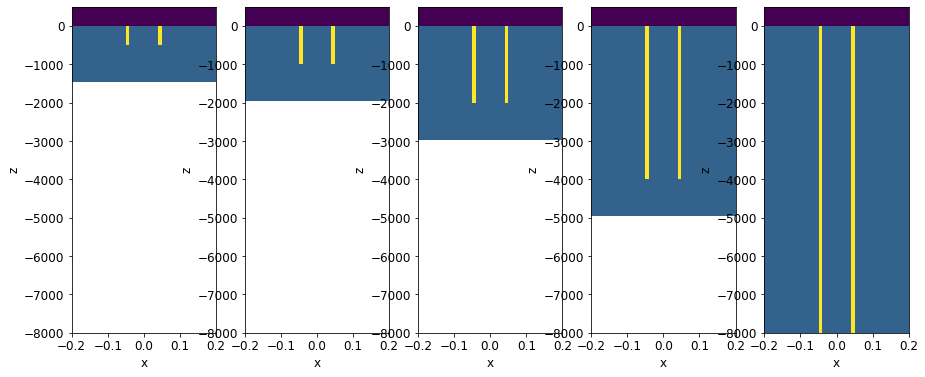

In [8]:
fig, ax = plt.subplots(1, len(casing_l), figsize=(3*len(casing_l), 6))

for i, l in enumerate(casing_l):
    meshes[l].plot_image(models[l], pcolor_opts={"norm":LogNorm()}, mirror=True, ax=ax[i])
    ax[i].set_xlim(0.2*np.r_[-1, 1])
    ax[i].set_ylim(np.r_[-np.max(casing_l), 500])

## set up the simulations

In [9]:
simulations = {}

for l, mesh in meshes.items():
    source = dc.sources.Dipole(location_a=src_a, location_b=src_b)
    survey = dc.Survey([source])

    simulations[l] = dc.Simulation3DCellCentered(
        mesh=mesh,
        sigmaMap=maps.IdentityMap(mesh),
        solver=Pardiso,
        survey=survey,
        bc_type='Dirichlet'
    )

In [10]:
fields = {}
for l in casing_l:
    t = time.time()
    print(f"starting {l}m")
    fields[l] = simulations[l].fields(models[l])
    print(f" ... done. {time.time()-t:1.2e} s")

starting 500m
 ... done. 1.26e+00 s
starting 1000m
 ... done. 3.28e+00 s
starting 2000m
 ... done. 6.10e+00 s
starting 4000m
 ... done. 1.12e+01 s
starting 8000m
 ... done. 2.23e+01 s


In [11]:
def get_currents(fields, casing_inds):
    mesh = fields.mesh
    j = discretize.utils.mkvc(fields[:, "j"])
    i = mesh.area * j
    iz = i[mesh.nFx:]
    iz = mesh.average_face_z_to_cell * iz
    iz[~casing_inds] = 0
    iz = iz.reshape(mesh.vnC[0], mesh.vnC[2], order="F")
    iz = iz.sum(0) 
    iz[
        (mesh.vectorCCz > -csz) | 
        (mesh.vectorCCz < mesh.cell_centers[casing_inds, 2].min())
    ] = np.nan
    return iz

In [12]:
def get_leak_off_currents(fields, casing_l):
    mesh = fields.mesh
    j = discretize.utils.mkvc(fields[:, "j"])
    i = mesh.area * j
    ix = i[:mesh.nFx]
    indsx = (
        (mesh.faces_x[:, 0]<casing_b+mesh.hx.min()/2) &
        (mesh.faces_x[:, 0]>casing_b-mesh.hx.min()/2)
    )
    ix = ix[indsx]
    ix[
        (mesh.vectorCCz > -csz) |
        (mesh.vectorCCz < -casing_l)
    ] = np.nan
    return ix

In [13]:
def get_charge_per_unit_length(fields, casing_inds): 
    mesh = fields.mesh
    charge = discretize.utils.mkvc(fields[:, "charge"])
    charge[~casing_inds] = 0
    charge = charge.reshape(mesh.vnC[0], mesh.vnC[2], order="F")
    charge = charge.sum(0) / mesh.hz
    charge[
        (mesh.vectorCCz > -csz) | 
        (mesh.vectorCCz < mesh.cell_centers[casing_inds, 2].min())
    ] = np.nan
    return charge

In [14]:
# compute charges and currents

currents = {}
leak_off_currents = {}
charges = {}

for l in casing_l:
    currents[l] = get_currents(fields[l], casing_indices[l])
    leak_off_currents[l] = get_leak_off_currents(fields[l], l)
    charges[l] = get_charge_per_unit_length(fields[l], casing_indices[l])

In [15]:
alpha = 1./(np.sqrt(1/sigma_back * sigma_casing * np.pi * (casing_b**2 - casing_a**2)))
def current_short_well(z, l):
    """
    current in a short well - decay is linear
    """
    return (1 - z/l)

def current_long_well(z):
    """
    current in a long well - decay is exponential and depends upon the parameter alpha
    """
    return np.exp(-alpha * z)

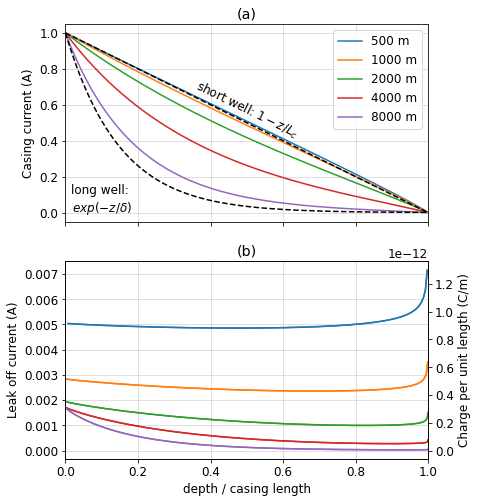

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(6.5, 8), sharex=True)

ax2 = ax[1].twinx()
for i, l in enumerate(casing_l):
    z = -meshes[l].vectorCCz/l
    ax[0].plot(z, -currents[l], label=f"{l} m")
    ax[1].plot(z, leak_off_currents[l])
    ax2.plot(z, charges[l])
    
ax[0].text(
    0.5, 0.57, "short well: $1-z/L_c$", ha="center", va="center", rotation=-26
)
ax[0].text(
    0.1, 0.07, "long well: \n$exp(- z / \delta)$", ha="center", va="center"
)

for i, a in enumerate(ax): 
    a.set_xlim([0, 1])
    a.grid("both", alpha=0.5)
    a.set_title(f"({ascii_lowercase[i]})")

ax[0].legend()
ax[0].set_ylabel("Casing current (A)")

ax[1].set_ylabel("Leak off current (A)")
ax[1].set_xlabel("depth / casing length")
ax2.set_ylabel("Charge per unit length (C/m)")

ztmp = np.linspace(0, 1, 100)
ax[0].plot(ztmp, current_short_well(ztmp, 1), "k--")
ax[0].plot(ztmp, current_long_well(ztmp*np.max(casing_l)), "k--")


# fig.savefig("./figures/finite-wells", dpi=200, bbox_inches="tight")